In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
latent_dims = 20
num_epochs = 30
batch_size = 256
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae_init = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae_init = vae_init.to(device)

num_params = sum(p.numel() for p in vae_init.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 647081


In [8]:
train_losses = []
def train_vae_gen(vae, sample_vae=False, sample_from=None):

  device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
  vae = vae.to(device)

  num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
  print('Number of parameters: %d' % num_params)

  optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

  vae.train()

  train_loss_avg = []

  print('Training ...')
  for epoch in range(num_epochs):
      train_loss_avg.append(0)
      num_batches = 0
      losses = []

      for image_batch, _ in train_dataloader:

          image_batch = image_batch.to(device)

          if sample_vae:
            with torch.no_grad():
              # image_batch = image_batch.to(device)
              latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
              image_batch = sample_from.decoder(latent)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
          losses.append(loss / batch_size)
          # backpropagation
          optimizer.zero_grad()
          loss.backward()

          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      train_losses.append(losses)
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [9]:
train_vae_gen(vae_init, False, None)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 25065.607210
Epoch [2 / 30] average reconstruction error: 25021.291797
Epoch [3 / 30] average reconstruction error: 24991.331454
Epoch [4 / 30] average reconstruction error: 24967.144315
Epoch [5 / 30] average reconstruction error: 24950.231591
Epoch [6 / 30] average reconstruction error: 24935.192167
Epoch [7 / 30] average reconstruction error: 24897.883170
Epoch [8 / 30] average reconstruction error: 24892.758826
Epoch [9 / 30] average reconstruction error: 24859.507505
Epoch [10 / 30] average reconstruction error: 24848.048338
Epoch [11 / 30] average reconstruction error: 24831.619477
Epoch [12 / 30] average reconstruction error: 24800.898155
Epoch [13 / 30] average reconstruction error: 24799.903657
Epoch [14 / 30] average reconstruction error: 24780.716439
Epoch [15 / 30] average reconstruction error: 24781.121464
Epoch [16 / 30] average reconstruction error: 24750.627369
Epoch [17 / 30] average

In [23]:
for i in range(30):
    for j in range(len(train_losses[i])):
        train_losses[i][j] = train_losses[i][j]

[array(99.3595, dtype=float32), array(109.222534, dtype=float32), array(98.86039, dtype=float32), array(105.50006, dtype=float32), array(101.517044, dtype=float32), array(96.47351, dtype=float32), array(100.50391, dtype=float32), array(99.19768, dtype=float32), array(99.93352, dtype=float32), array(98.713745, dtype=float32), array(98.32673, dtype=float32), array(99.23135, dtype=float32), array(98.509026, dtype=float32), array(98.80228, dtype=float32), array(98.47753, dtype=float32), array(97.5558, dtype=float32), array(97.32033, dtype=float32), array(97.57848, dtype=float32), array(96.736404, dtype=float32), array(98.60442, dtype=float32), array(100.08419, dtype=float32), array(99.15248, dtype=float32), array(96.149445, dtype=float32), array(98.09227, dtype=float32), array(99.24968, dtype=float32), array(99.804825, dtype=float32), array(98.33557, dtype=float32), array(98.35083, dtype=float32), array(97.44493, dtype=float32), array(98.90228, dtype=float32), array(99.13269, dtype=float32

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  8., 17.,
        19., 38., 40., 42., 30., 16.,  7.,  8.,  5.]),
 array([ 36.78659439,  37.43776703,  38.08893967,  38.7401123 ,
         39.39128494,  40.04245758,  40.69363022,  41.34480286,
         41.99597549,  42.64714813,  43.29831696,  43.94948959,
         44.60066223,  45.25183487,  45.90300751,  46.55418015,
         47.20535278,  47.85652542,  48.50769806,  49.1588707 ,
         49.81004333,  50.46121597,  51.11238861,  51.76356125,
         52.41473389,  53.06590652,  53.71707916, 

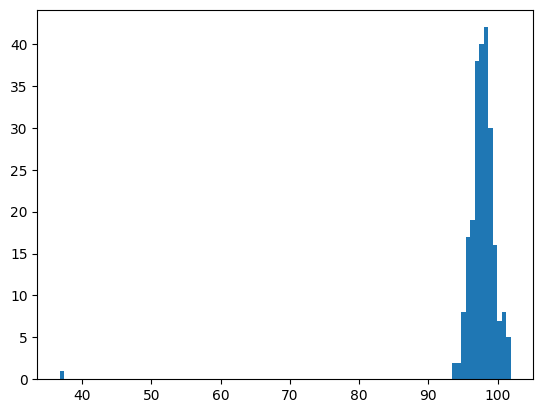

In [25]:
import numpy as np
import matplotlib.pyplot as plt

print(train_losses[0])
plt.hist(train_losses[2], bins=100)

Original images


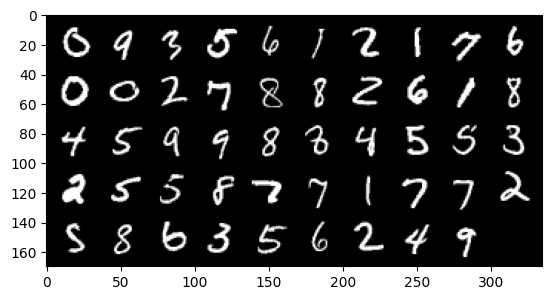

VAE reconstruction:


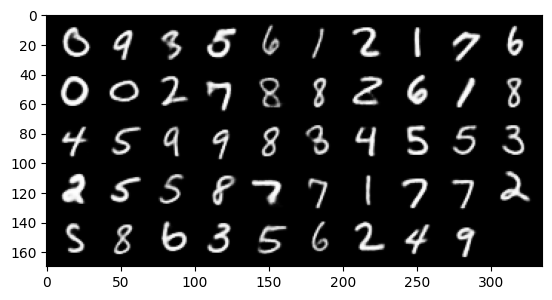

In [7]:

plt.ion()

import torchvision.utils

vae_init.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

for images, labels in test_dataloader:
  break

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_init)

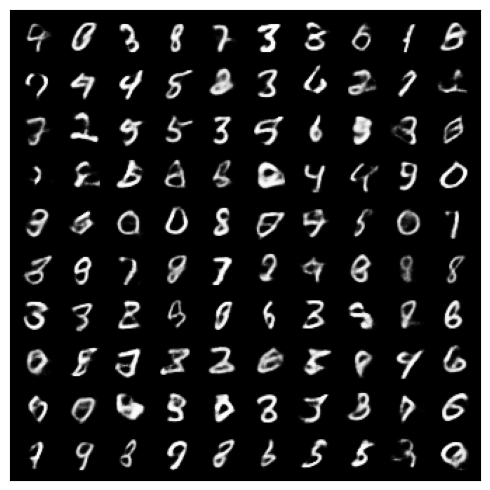

In [8]:
latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = vae_init.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()


0
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 42538.720853
Epoch [2 / 30] average reconstruction error: 33825.824867
Epoch [3 / 30] average reconstruction error: 32856.213427
Epoch [4 / 30] average reconstruction error: 32493.173749
Epoch [5 / 30] average reconstruction error: 32124.111312
Epoch [6 / 30] average reconstruction error: 31999.835879
Epoch [7 / 30] average reconstruction error: 31880.399032
Epoch [8 / 30] average reconstruction error: 31770.145225
Epoch [9 / 30] average reconstruction error: 31714.341086
Epoch [10 / 30] average reconstruction error: 31616.388173
Epoch [11 / 30] average reconstruction error: 31541.375557
Epoch [12 / 30] average reconstruction error: 31518.977431
Epoch [13 / 30] average reconstruction error: 31447.418301
Epoch [14 / 30] average reconstruction error: 31427.594452
Epoch [15 / 30] average reconstruction error: 31404.101658
Epoch [16 / 30] average reconstruction error: 31353.123903
Epoch [17 / 30] avera

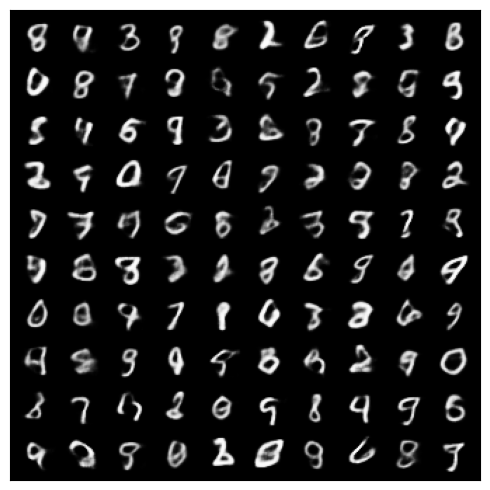

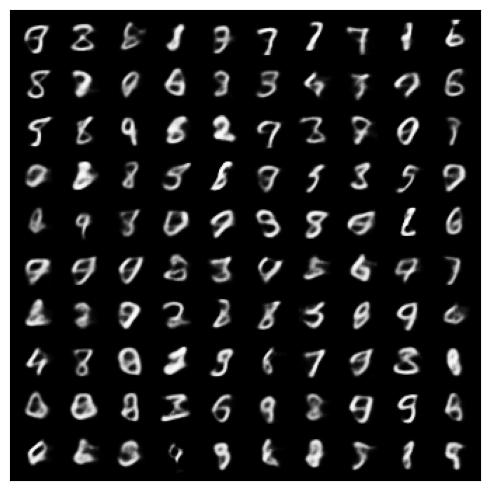

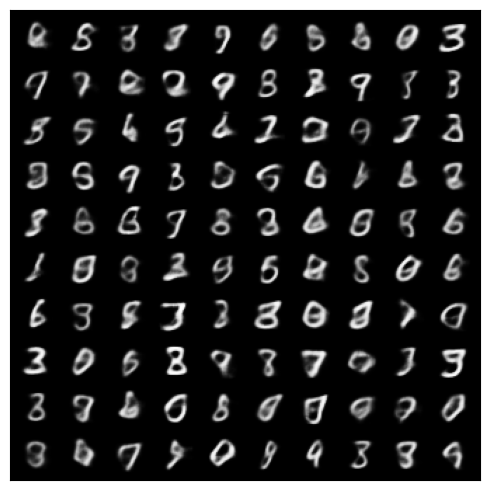

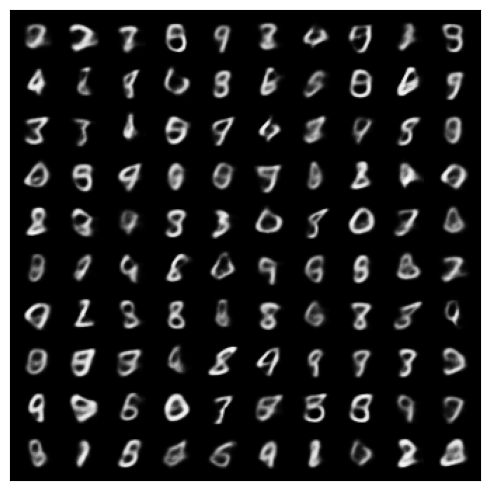

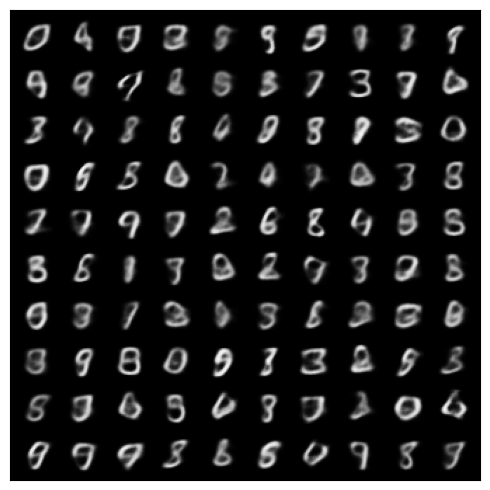

In [9]:
muss = []

last_vae = vae_init

for gen_number in range(5):
  print(gen_number)

  vae_gen = VariationalAutoencoder()
  vae_gen = vae_gen.to(device)

  train_vae_gen(vae_gen, True, last_vae)

  last_vae = vae_gen

  latent = torch.randn(100, latent_dims, device=device)
  img_recon = vae_gen.decoder(latent)

  img_recon = img_recon.cpu()

  fig, ax = plt.subplots(figsize=(5, 5))
  show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
  # plt.show()
  plt.xticks([])
  plt.yticks([])

  plt.tight_layout()

  mus, vars   = vae_init.encoder(img_recon.to('cuda'))
  mus = mus.cpu().detach().numpy(); vars = vars.cpu().detach().numpy()

  muss.append(mus)

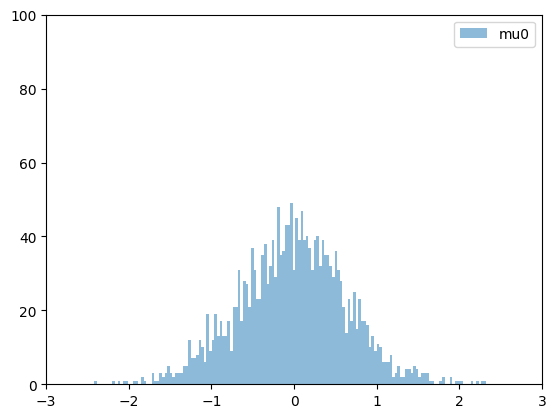

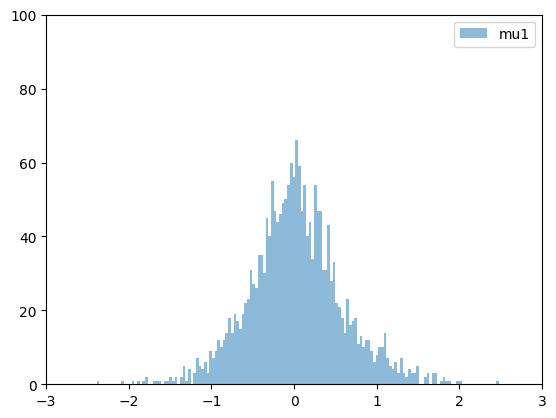

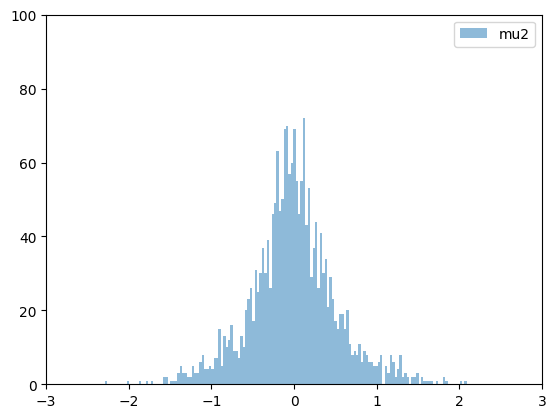

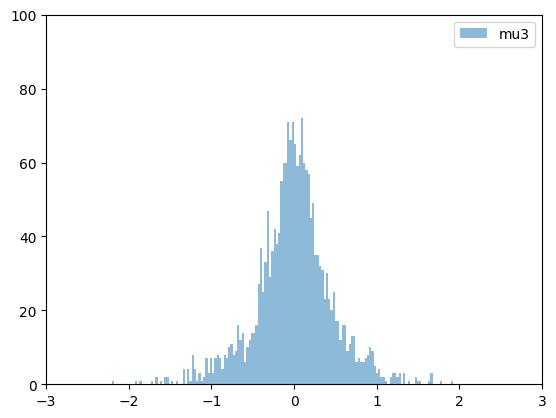

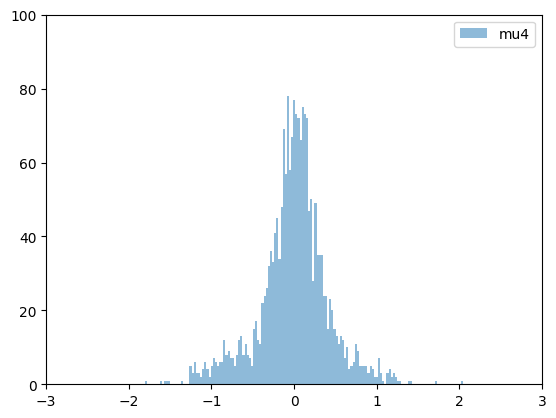

In [10]:
for i, mus in enumerate(muss):
  plt.figure()
  plt.hist(mus.flatten(), bins=150, label = f"mu{i}", alpha=0.5)
  plt.xlim(-3,3)
  plt.ylim(0, 100)
  plt.legend()
  plt.show()

tensor([[-0.3836, -0.1390,  0.2036,  ..., -0.0305,  0.2647, -0.1405],
        [-0.4315, -0.2225,  0.3474,  ...,  0.3470,  0.1671,  0.1594],
        [-0.5952, -0.0704,  0.0276,  ..., -0.5281,  0.1275,  0.1642],
        ...,
        [-0.3410, -0.3171,  0.1824,  ...,  0.2946,  0.3640,  0.3038],
        [-0.9280, -0.2230,  0.2466,  ..., -0.7978,  0.2257,  0.5349],
        [ 0.4714, -0.0514, -0.0411,  ..., -0.4804, -0.0496, -0.3165]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


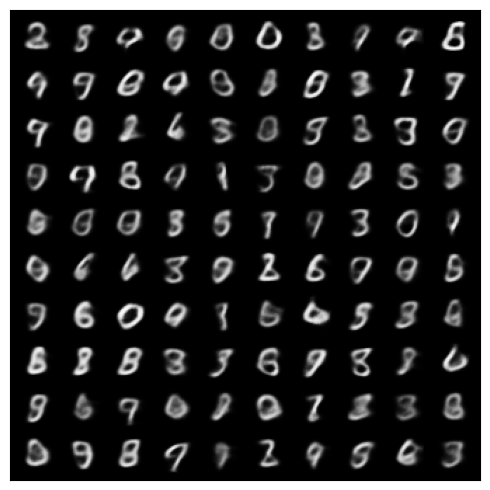

In [11]:
latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = last_vae.decoder(latent)
mus, vars   = vae_init.encoder(img_recon.to('cuda'))
print(mus)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
plt.xticks([])
plt.yticks([])

plt.tight_layout()

Gen 0 -0.016020624 0.6525578
Gen 1 0.023671256 0.5667511
Gen 2 -0.009135926 0.5187279
Gen 3 -0.003073101 0.46485165
Gen 4 -0.0040141554 0.41698688


/tmp/ipykernel_3201095/1563294549.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals, hist=False, kde=True,
/tmp/ipykernel_3201095/1563294549.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals, hist=False, kde=True,
/tmp/ipykernel_3201095/1563294549.py:10: UserWar

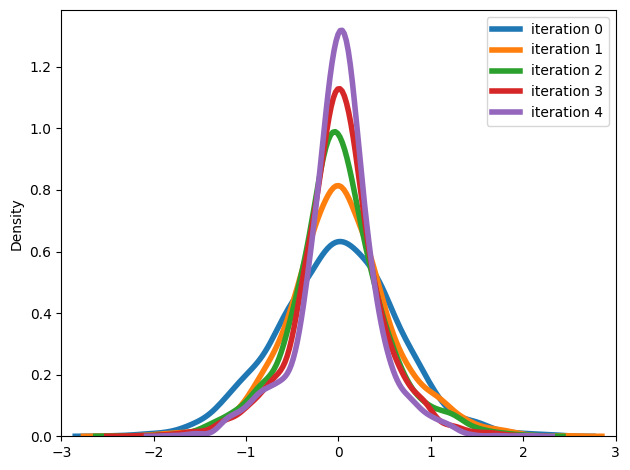

In [18]:
import seaborn as sns


plt.figure()

for i, mus in enumerate(muss):
  vals = mus.flatten()
  print(f"Gen {i}", np.mean(vals), np.std(vals))
  
  sns.distplot(vals, hist=False, kde=True,
               bins=int(100),
               kde_kws={'linewidth': 4}, label=f"iteration {i}")
plt.xlim(-3,3)
plt.legend()
plt.tight_layout()


In [21]:

mu_sig = [
  [
    (0.014538932, 0.6995303),
    (0.032151498, 0.60134965),
    (-0.012714024, 0.5541111),
    (0.0055421903, 0.48931533),
    (0.013153562, 0.46653777)
  ],
  [
    (-0.012844566, 0.69527394),
    (0.018827086, 0.59368867),
    (-0.015168274, 0.5296458),
    (-0.019374713, 0.48430806),
    (-0.014797333, 0.4310458),
  ],
  [
    (-0.012720791, 0.6922824),
    (-0.029163573, 0.60909194),
    (-0.009332741, 0.53359216),
    (-0.012893185, 0.4891546),
    (-0.031725854, 0.45829764),
  ],
  [
  (0.022953195, 0.67841727),
  (0.045430116, 0.605033),
  (0.05141772, 0.52345085),
  (0.047837593, 0.48296788),
  (0.07407785, 0.42802373),
  ],
  [
    (0.0037199787, 0.67357385),
    (0.037649374, 0.60761327),
    (0.028401546, 0.5273319),
    (0.051906876, 0.46807787),
    (0.055885438, 0.43289876),
  ],
]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3201095/4191329116.py:3: SyntaxWarning: invalid escape sequence '\m'
  for ind, what in [(0, "$\mu$"), (1, "$\sigma$")]:
/tmp/ipykernel_3201095/4191329116.py:3: SyntaxWarning: invalid escape sequence '\s'
  for ind, what in [(0, "$\mu$"), (1, "$\sigma$")]:


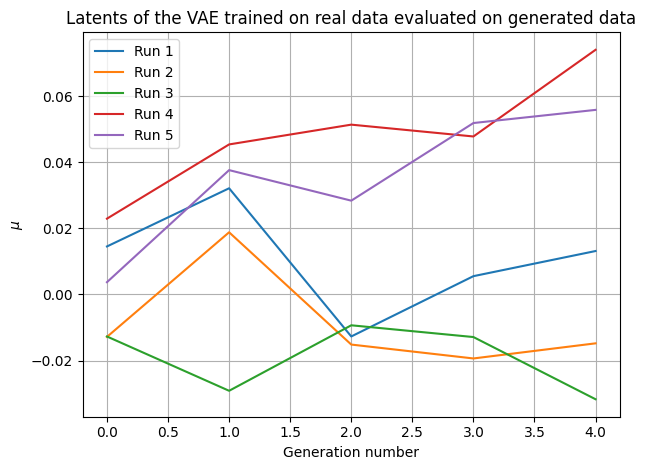

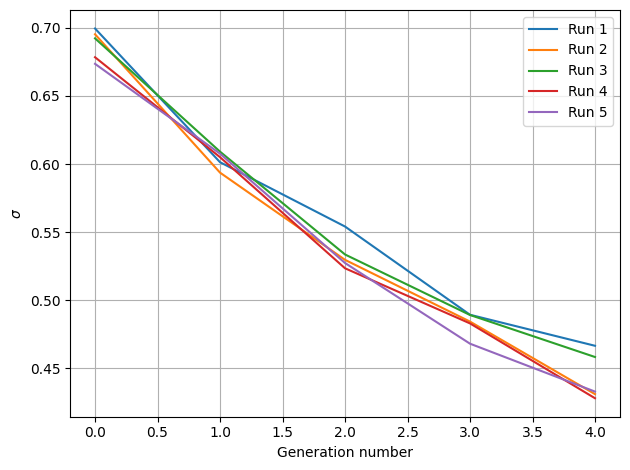

In [22]:
import matplotlib.pyplot as plt

for ind, what in [(0, "$\mu$"), (1, "$\sigma$")]:
  plt.figure()
  for i, run in enumerate(mu_sig):
    plt.plot([x[ind] for x in run], label=f"Run {i+1}")
  plt.legend()
  if ind == 0:
    plt.title("Latents of the VAE trained on real data evaluated on generated data")

  plt.ylabel(what)
  plt.xlabel("Generation number")
  plt.grid()
  plt.tight_layout()